事例について触れたので今度は実際に転移学習をやってみましょう。

CIFAR-10という10種類の物体カラー写真のデータセットと画像認識で有名なモデルの一つであるVGG16を使用します。

VGG16は畳み込み層13層、全結合層3層、1000クラスを分類するニューラルネットワークで2014年にILSVRCという画像認識の技術を競うコンペで優勝したという実績のあるもの。

世界レベルの精度で1000クラスを分類できるモデルを活用すれば10種類の分類など赤子の手を捻るように見えますよね。

それでは進めていきましょう。

今回はGoogle ColabでTensorFlowやKerasも使用します。

### ライブラリとデータの読み込み

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import vgg16 as VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping
!pip install dlt #必要に応じ使用
import dlt
import os
import numpy as np
import matplotlib.pyplot as plt
#https://www.tensorflow.org/tutorials/images/classification?hl=ja
print(tf.__version__)

2.4.1


In [ ]:
data = dlt.cifar.load_cifar10()

# 画像の簡単な前処理
# ベクトル形式に変更
# RGB 255 = white, 0 = black
X_train = data.train_images.reshape([-1, 32, 32, 3])
X_test = data.test_images.reshape([-1, 32, 32, 3])
print('%i training samples' % X_train.shape[0])
print('%i test samples' % X_test.shape[0])
print(X_train.shape)

# RGBの数値(0-255)を(0-1)に変更
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# クラスのラベルをワンホットエンコーディングに変更
Y_train = to_categorical(data.train_labels, 10)
Y_test = to_categorical(data.test_labels, 10)

50000 training samples
10000 test samples
(50000, 32, 32, 3)


今回のデータは

幅32×高さ32ピクセルで1つ分のデータが基本的に(3, 32, 32)もしくは(32, 32, 3)(=計3072要素)という多次元配列の形状となっています。

最初もしくは最後の次元にある3要素がRGB値。

訓練用データで50,000枚、テスト用は10,000枚揃えられています。

### 層の追加とネットワーク構造の固定

次に層を重ねていきます。

Xceptionという構造を使いすべての層を通過した後のモデルのインスタンスをbase_modelとして取り出します。

include_topというところをFalseにしないと転移学習ができなくなるので要注意です。

In [ ]:
# ベースモデルの作成
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [ ]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

続けてネットワーク構造を固定。

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

base_modelの後に追加された層はCIFAR-10の学習で影響を受けることで重みが更新されます。

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 層を追加
x = Dense(1024, activation='relu')(x)
# さらに層を追加
predictions = Dense(10, activation='softmax')(x)

# 今回使用するモデルがこれ
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

ネットワークの構造が決まったのでモデルをコンパイルし精度まで見ていきましょう。

In [ ]:
print(model.summary())

model.compile(
loss='categorical_crossentropy',
optimizer=Adam(lr=0.001),
metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

fit = model.fit(X_train, Y_train,
              batch_size=128,
              epochs=40, 
              verbose=2,
              validation_split=0.1,
              callbacks=[es]
                )

score = model.evaluate(X_test, Y_test,
                    verbose=0
                    )
print('Test score:', score[0])
print('Test accuracy:', score[1])


# 出力先の作成
folder = 'results'
if not os.path.exists(folder):
    os.makedirs(folder)
    
model.save(os.path.join(folder, 'my_model_tl.h5'))

# モデルから予測
preds = model.predict(X_test)
cls = np.argmax(preds,axis=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

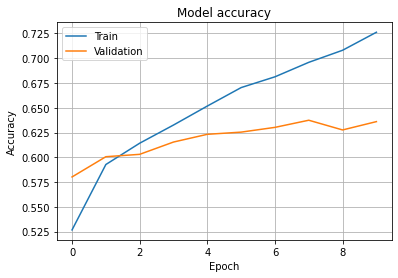

In [ ]:
# 精度を可視化
for i in range(10):
    dlt.utils.plot_prediction(
        preds[i],
        data.test_images[i],
        data.test_labels[i],
        data.classes,
        fname=os.path.join(folder, 'test-%i.png' % i))

plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

精度は上のように変わっていきました。

転移学習については以上のような段階を踏みます。

より精度を上げていく方法の一つとしてファインチューニングをしハイパーパラメータを調整するというのが挙げられます。